# Implementare Simplă a Perceptronului
_de Mihai Dan Nadăș (mihai.nadas@ubbcluj.ro), Ianuarie 2025_

Acest notebook implementează o versiune a perceptronului, așa cum a fost introdusă în lucrarea din 1958 a lui Frank Rosenblatt, "The Perceptron: A Probabilistic Model for Information Storage and Organization in the Brain."

Vom utiliza concepte matematice de bază, minimizând algebră liniară (vectri și matrici) acolo unde este posibil.

## Introducere în Perceptron

Un perceptron este un model computațional simplu al unui neuron. Acesta formează fundația rețelelor neuronale și funcționează prin preluarea de intrări ponderate și aplicarea unei funcții de prag pentru a produce o ieșire. Acest notebook arată cum pot fi folosiți perceptronii pentru a clasifica date separabile liniar.

## Obiectiv

Obiectivul este să antrenăm un model cu două ponderi, $w_1$ și $w_2$, corespunzătoare coordonatelor $x$ și $y$ ale unui punct $(x, y)$, împreună cu un bias $b$. Acest lucru se aliniază cu formula pendinte-intercept a unei drepte, $y = mx + c$.

Modelul va aborda o sarcină simplă de clasificare pe un set de date separabil liniar bazat pe următoarea funcție:

$
f: \mathbb{N} \to \mathbb{N}, \quad f(x) =
\begin{cases}
x, & \text{dacă } x \bmod 2 = 0, \\
2x, & \text{dacă } x \bmod 2 = 1.
\end{cases}
$

## Set de Date

Vom genera un set de date folosind Biblioteca Standard Python. Setul de date constă în puncte determinate de funcția de mai sus, clasificate în două clase. Această configurație ne permite să antrenăm eficient clasificatorul nostru perceptron.

In [20]:
import random


def generate_dataset(num_items=20, start=0, stop=100):
    random.seed(42)
    dataset = []
    x1_values = set()
    while len(dataset) < num_items:
        x1 = random.randint(start, stop)
        if x1 in x1_values:
            continue
        x1_values.add(x1)
        x2 = x1 if x1 % 2 == 0 else 2 * x1
        y = (
            0 if x1 == x2 else 1
        )  # (x1, x2) este etichetat ca Clasa 0 dacă x1 este par, și Clasa 1 altfel
        dataset.append((x1, x2, y))
    return dataset


dataset = generate_dataset()

# acum să împărțim setul de date în seturi de antrenament și testare
train_ratio = 0.8
num_train = int(len(dataset) * train_ratio)
dataset_train, dataset_test = dataset[:num_train], dataset[num_train:]
print(f"Setul de antrenament (n={len(dataset_train)}): {dataset_train}")
print(f"Setul de testare (n={len(dataset_test)}): {dataset_test}")

Setul de antrenament (n=16): [(81, 162, 1), (14, 14, 0), (3, 6, 1), (94, 94, 0), (35, 70, 1), (31, 62, 1), (28, 28, 0), (17, 34, 1), (13, 26, 1), (86, 86, 0), (69, 138, 1), (11, 22, 1), (75, 150, 1), (54, 54, 0), (4, 4, 0), (27, 54, 1)]
Setul de testare (n=4): [(29, 58, 1), (64, 64, 0), (77, 154, 1), (71, 142, 1)]


## Reprezentarea Vizuală

Folosind _Matplotlib_ și _pandas_, vom reprezenta vizual seturile de date pentru antrenament și testare. Acest lucru ne va ajuta să înțelegem cum sunt distribuite datele noastre și să observăm cum ar putea fi separate cele două clase. Să continuăm prin a reprezenta grafic punctele de date cu markeri și culori distincte pentru fiecare clasă și tip de set de date.

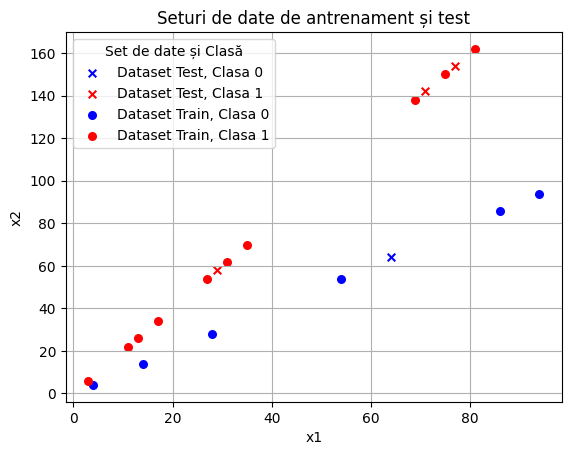

In [21]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_datasets(train_dataset, test_dataset):
    # Combină seturile de date într-un DataFrame pentru o manipulare mai ușoară
    train_df = pd.DataFrame(train_dataset, columns=["x1", "x2", "class"])
    train_df["set"] = "Train"

    test_df = pd.DataFrame(test_dataset, columns=["x1", "x2", "class"])
    test_df["set"] = "Test"

    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Definește culorile și marcajele
    colors = {0: "blue", 1: "red"}
    markers = {"Train": "o", "Test": "x"}

    # Plotează fiecare grup folosind Matplotlib
    fig, ax = plt.subplots()
    for (dataset, cls), group in combined_df.groupby(["set", "class"]):
        ax.scatter(
            group["x1"],
            group["x2"],
            color=colors[cls],
            label=f"Dataset {dataset}, Clasa {cls}",
            s=30,
            marker=markers[dataset],
        )

    # Gestionează legenda și etichetele
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Set de date și Clasă", loc="best")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title("Seturi de date de antrenament și test")
    ax.grid(True)


plot_datasets(dataset_train, dataset_test)
plt.show()

## Definirea unui Clasificator Liniar

Cu setul nostru de date pregătit, ne concentrăm acum pe fundația matematică care permite modelului nostru să clasifice intrările $x_{1}$ și $x_{2}$ în clasele $0$ sau $1$. Matematic, aceasta poate fi reprezentată astfel:

$
c: \mathbb{R}^2 \to \{0,1\}, \quad
c(x_{1}, x_{2}) =
\begin{cases} 
1, & \text{dacă } (x_{1}, x_{2}) \in \text{Clasa 1}, \\
0, & \text{dacă } (x_{1}, x_{2}) \in \text{Clasa 2}.
\end{cases}
$

Această clasificare folosește reprezentarea algebrică a unei linii într-un sistem de coordonate carteziene, descrisă de:

$
z(x) = w_{1}x_{1} + w_{2}x_{2} + b,
$

unde:
- $w_{1}$ și $w_{2}$ sunt ponderi care influențează panta liniei, dictând unghiul acesteia în raport cu axa $x$.
- $b$ este bias-ul (sau interceptul), indicând locul unde linia intersectează axa $y$.

Din graficul desenat mai sus, cele două clase sunt vizibil separabile liniar, justificând utilizarea unei frontiere de decizie liniare. Antrenarea ponderilor $w_{1}$ și $w_{2}$ folosind algoritmul Perceptron oferă o abordare ideală pentru stabilirea acestei frontiere.

Pentru a ilustra, considerați o linie definită de $w_{1}=1$, $w_{2}=0.5$, și $b=0$. Apariția acestei linii pe graficul anterior ajută la definirea modului în care separă bine clasele noastre.

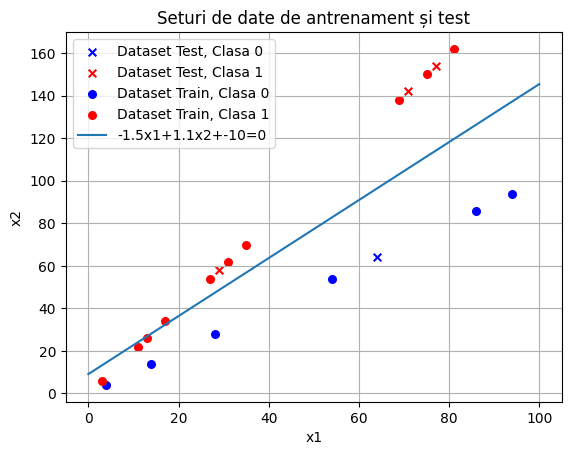

In [22]:
zx = lambda x1, x2, w1, w2, c: w1 * x1 + w2 * x2 + c

def plot_zx(w1, w2, c):
    x2 = lambda x1: (
        (-w1 * x1 - c) / w2 if w2 != 0 else -c / w1 if w1 != 0 else c
    )  # acesta este pentru că ecuația dreptei este w1*x1 + w2*x2 + c = 0, prin urmare x2 = (-w1*x1 - c) / w2
    x1_values = range(0, 101)
    x2_values = [x2(x1) for x1 in x1_values]
    plt.plot(x1_values, x2_values, label=f"{w1}x1+{w2}x2+{c}=0")
    plt.legend(loc="best")

def plot_datasets_and_zx(w1, w2, c):
    plot_datasets(dataset_train, dataset_test)
    plot_zx(w1, w2, c)

plot_datasets_and_zx(-1.5, 1.1, -10)

În această configurație, punctele de date sunt separate clar de frontiera de decizie. Totuși, există configurații alternative pentru $w_{1},\ w_{2},$ și $c$ care duc la o separare mai puțin optimă. De exemplu, stabilirea lui $w_{1}=0.1,\ w_{2}=0.1,$ și $c=0.5$ duce la o frontieră de decizie mai puțin eficientă.

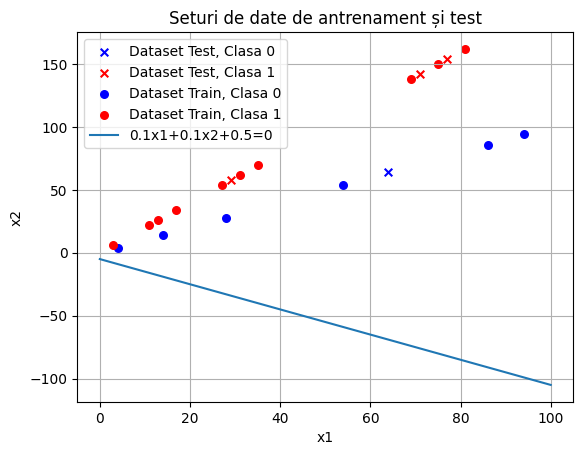

In [23]:
plot_datasets_and_zx(0.1, 0.1, 0.5)

În acest caz particular, $z$ nu va ajuta la clasificarea eficientă a niciunui punct de date.

## Evaluarea Performanței Clasificatorului

Cu $z = w_{1}x_{1} + w_{2}x_{2} + c$ definit ca fiind limita de decizie a clasificatorului nostru, am observat vizual că poate clasifica folosind anumite valori alese. Acum, să determinăm computațional performanța sa folosind metrica de _acuratețe_.

### Definirea Clasificatorului

Înainte de a evalua performanța clasificatorului, să îl definim clar:

$
c: \mathbb{N} \times \mathbb{N} \to \{0,1\}, \quad
c(x_{1},x_{2}) =
\begin{cases} 
1, & \text{dacă } z(x_{1}, x_{2}) \geq 0, \\
0, & \text{dacă } z(x_{1}, x_{2}) < 0.
\end{cases}
$

În esență, aceasta înseamnă că dacă un punct $(x_1, x_2)$ se află pe sau deasupra limitei de decizie $z(x_1, x_2)$, este clasificat ca $1$ (Clasa 1); altfel, este clasificat ca $0$ (Clasa 0).

Să implementăm clasificatorul în cod, și apoi să discutăm cum putem evalua performanța lui în mod eficient.

In [24]:
cx = lambda x1, x2, w1, w2, c: 1 if zx(x1, x2, w1, w2, c) >= 0 else 0


def accuracy(dataset, w1, w2, c):
    print(f"Calcularea acurateței pe setul de antrenament folosind w1={w1}, w2={w2}, c={c}")
    correct = 0
    for x1, x2, y in dataset:
        if y == cx(x1, x2, w1, w2, c):
            correct += 1
    print(
        f"Acuratețea rezultată: {correct}/{len(dataset)}, sau {correct/len(dataset)*100:.2f}%"
    )
    return correct / len(dataset)


# Aplicarea funcției de acuratețe pe setul de antrenament folosind cele două seturi de greutăți și bias, așa cum este arătat mai sus, în primul exemplu
accuracy(dataset_train, -1.5, 1.1, -10)

# Aplicarea funcției de acuratețe pe setul de antrenament folosind două seturi de greutăți și bias, așa cum este arătat mai sus, în al doilea exemplu
accuracy(dataset_train, 0.1, 0.1, 0.5)

Calcularea acurateței pe setul de antrenament folosind w1=-1.5, w2=1.1, c=-10
Acuratețea rezultată: 13/16, sau 81.25%
Calcularea acurateței pe setul de antrenament folosind w1=0.1, w2=0.1, c=0.5
Acuratețea rezultată: 10/16, sau 62.50%


0.625

### Discuție despre Acuratețe

Anterior, am observat cum modificarea greutăților și a bias-ului afectează acuratețea modelului nostru de perceptron. Această variație apare deoarece fiecare set de greutăți și bias definește o limită de decizie unică, care influențează capacitatea modelului de a clasifica corect punctele de date. Obiectivul principal este de a determina valorile "optime" pentru acești parametri, un proces realizat prin _antrenarea modelului_.

## Antrenarea Modelului

Pe baza analizei noastre, vom antrena modelul nostru de perceptron iterativ, ajustând fin greutățile și bias-ul. Acest antrenament implică ajustări pe parcursul mai multor epoci—cicluri de învățare prin setul de date—permițând modelului să îmbunătățească treptat acuratețea. Ideea este de a actualiza iterativ acești parametri pentru a se potrivi mai bine sarcinii noastre de clasificare și caracteristicilor setului de date, îmbunătățind astfel performanța generală a modelului.

In [25]:
# Mai întâi, să inițializăm ponderile și biasul la zero
w1, w2, c = 0, 0, 0

# Acum să definim rata de învățare
learning_rate = 0.1

# Acum să definim numărul de epoci
num_epochs = 5

# Creăm un DataFrame pentru a stoca detaliile epocilor
epoch_data = []

# Să începem acum bucla de antrenare
for epoch in range(num_epochs):
    print(f"Epoca {epoch+1}")
    error = 0
    for x1, x2, y in dataset_train:
        z = zx(x1, x2, w1, w2, c)
        y_hat = 1 if z >= 0 else 0
        if y != y_hat:
            error += 1 # Numărăm numărul de erori
        w1 += learning_rate * (y - y_hat) * x1
        w2 += learning_rate * (y - y_hat) * x2
        c += learning_rate * (y - y_hat)
        print(f"  x1={x1}, x2={x2}, y={y}, z={z:.2f}, y_hat={y_hat}, w1={w1:.2f}, w2={w2:.2f}, c={c:.2f}")
        # Adăugăm detaliile în DataFrame
    epoch_data.append({
        "epoch": epoch + 1,
        "x1": x1,
        "x2": x2,
        "y": y,
        "z": z,
        "y_hat": y_hat,
        "w1": w1,
        "w2": w2,
        "c": c,
        "err": error
    })

epoch_details = pd.DataFrame(epoch_data)

# Afișăm DataFrame-ul
epoch_details.head()

Epoca 1
  x1=81, x2=162, y=1, z=0.00, y_hat=1, w1=0.00, w2=0.00, c=0.00
  x1=14, x2=14, y=0, z=0.00, y_hat=1, w1=-1.40, w2=-1.40, c=-0.10
  x1=3, x2=6, y=1, z=-12.70, y_hat=0, w1=-1.10, w2=-0.80, c=0.00
  x1=94, x2=94, y=0, z=-178.60, y_hat=0, w1=-1.10, w2=-0.80, c=0.00
  x1=35, x2=70, y=1, z=-94.50, y_hat=0, w1=2.40, w2=6.20, c=0.10
  x1=31, x2=62, y=1, z=458.90, y_hat=1, w1=2.40, w2=6.20, c=0.10
  x1=28, x2=28, y=0, z=240.90, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=17, x2=34, y=1, z=108.80, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=13, x2=26, y=1, z=83.20, y_hat=1, w1=-0.40, w2=3.40, c=0.00
  x1=86, x2=86, y=0, z=258.00, y_hat=1, w1=-9.00, w2=-5.20, c=-0.10
  x1=69, x2=138, y=1, z=-1338.70, y_hat=0, w1=-2.10, w2=8.60, c=0.00
  x1=11, x2=22, y=1, z=166.10, y_hat=1, w1=-2.10, w2=8.60, c=0.00
  x1=75, x2=150, y=1, z=1132.50, y_hat=1, w1=-2.10, w2=8.60, c=0.00
  x1=54, x2=54, y=0, z=351.00, y_hat=1, w1=-7.50, w2=3.20, c=-0.10
  x1=4, x2=4, y=0, z=-17.30, y_hat=0, w1=-7.50, w2=3.20, c=-0.10

,epoch,x1,x2,y,z,y_hat,w1,w2,c,err
0,1,27,54,1,-29.8,0,-4.8,8.6,0.0,8
1,2,27,54,1,124.1,1,-11.8,8.2,-0.1,5
2,3,27,54,1,124.1,1,-11.8,8.2,-0.1,0
3,4,27,54,1,124.1,1,-11.8,8.2,-0.1,0
4,5,27,54,1,124.1,1,-11.8,8.2,-0.1,0


### Interpretarea Rezultatelor

După antrenarea modelului nostru, haideți să examinăm rezultatele. Observați cum greutățile $w_1$ și $w_2$, împreună cu bias-ul $c$, se schimbă cu fiecare epocă. Aceste ajustări demonstrează învățarea perceptronului pe măsură ce devine mai capabil să clasifice punctele de date. Fiecare iterație ajută la minimizarea erorilor de clasificare, îmbunătățind astfel acuratețea predictivă a modelului.

Urmărim punctele clasificate greșit pe epocă pentru a evalua procesul de învățare. Coloana `err` din DataFrame arată această progresie. Pe măsură ce modelul învață, numărul clasificărilor greșite scade—un semn că devine mai bun în a distinge între punctele de date. Remarcabil, până la sfârșitul celei de-a doua epoci, modelul clasifică corect toate punctele.

## Vizualizarea Frontierei de Decizie

Cu greutățile și bias-ul finalizate, putem trasa frontiera de decizie—o linie modelată de ecuația $z = w_{1}x_{1} + w_{2}x_{2} + c$. Acest grafic ilustrează cum perceptronul separă diferitele clase din dataset. Vizualizările interactive de mai jos îmbunătățesc înțelegerea prin arătarea modului în care modificările în greutăți și bias afectează frontiera de decizie.

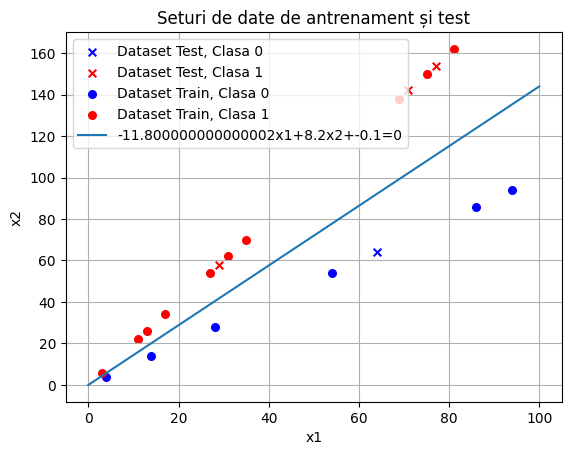

In [26]:
plot_datasets_and_zx(w1, w2, c)

După cum putem observa, frontiera de decizie separă eficient cele două clase din setul de date, indicând faptul că modelul a învățat să clasifice punctele de date pe baza valorilor $w_{1}$, $w_{2}$ și $c$. Nu-i așa că este fascinant?

## Vizualizare Interactivă
Pentru a consolida această înțelegere, haideți să construim o vizualizare interactivă. Aceasta ne va permite să vedem cum modificarea ponderilor și a bias-ului schimbă frontiera de decizie. Un astfel de component interactiv va îmbunătăți perceperea noastră cu privire la modul în care modelul distinge între cele două clase.

In [27]:
from ipywidgets import interact

trained_w1 = w1
trained_w2 = w2
trained_c = c
print(f"Trained weights: w1={trained_w1}, w2={trained_w2}, c={trained_c}")

def plot_dynamic_line(w1=trained_w1, w2=trained_w2, c=trained_c):
    plot_datasets(dataset_train, dataset_test)
    plot_zx(w1, w2, c)

# Aceasta va afișa un grafic interactiv care îți permite să schimbi ponderile și bias-ul. Valorile implicite sunt ponderile și bias-ul antrenat.
interact(plot_dynamic_line, w1=(-20, 20, 0.5), w2=(-20, 20, 0.5), c=(-50, 50, 0.5))

Trained weights: w1=-11.800000000000002, w2=8.2, c=-0.1


interactive(children=(FloatSlider(value=-11.800000000000002, description='w1', max=20.0, min=-20.0, step=0.5),…

<function __main__.plot_dynamic_line(w1=-11.800000000000002, w2=8.2, c=-0.1)>

Joacă-te cu "butoanele" $w_1, w_2$, și $c$ pentru a vedea cum se schimbă frontiera decizională. Pe măsură ce ajustezi greutățile și biasul, poziția și unghiul liniei se vor schimba, oferind o modalitate practică de a vizualiza cum modelul face clasificări pe baza acestor parametri.

# Concluzie
Acest notebook a prezentat o implementare introductivă a unui model perceptron cu accent pe elevii tineri. Am generat și vizualizat un set de date, am dezvoltat un clasificator liniar, i-am evaluat performanța și am antrenat modelul iterativ pentru a-i îmbunătăți acuratețea. Prin analizarea îmbunătățirilor de performanță, s-a evidențiat faptul că rata de eroare a scăzut în timp, subliniind capacitatea modelului de a învăța eficient până la al doilea ciclu.

## Limitări și Lucrări Viitoare
Deși perceptronul este eficient pentru date care pot fi separate liniar, întâmpină dificultăți cu seturile de date care nu pot fi separate printr-o singură linie dreaptă. Pentru date care nu pot fi separate liniar, sunt necesare modele mai complexe. Încercările viitoare ar putea include explorarea:

- Neuronul Liniar Adaptativ (Adaline), folosind activări liniare continue.
- Modele de regresie logistică folosind activări sigmoid.
- Perceptroni multi-strat (MLPs) pentru seturi de date mai complexe.
- Rețele Neuronale Convoluționale (CNNs) pentru date de imagine.
- Rețele Neuronale Recurente (RNNs) pentru date de secvență.
- Rețele Generative Adversariale (GANs) pentru crearea de mostre de date.
- Modele Transformer pentru diverse sarcini de procesare a limbajului natural, incluzând configurații numai cu encoder, numai cu decoder și encoder-decoder.

Aceste proiecte promit învățare și explorare ulterioară, așa că rămâneți pe aproape pentru viitoarele progrese!